In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pgzip as gz
import _pickle as pkl
import gc

import pandas as pd

In [2]:
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPool1D, Flatten

## X1: Seq, X2: Gene, Y: Peak

In [3]:
with gz.open('TR_DATA/data_X1.pkl.gz') as f:
    NP_seq = pkl.load(f)

In [4]:
with gz.open('TR_DATA/data_X2_enc.pkl.gz') as f:
    NP_gene = pkl.load(f)

In [5]:
with gz.open('TR_DATA/data_Ys.pkl.gz') as f:
    NP_peak = pkl.load(f)

In [6]:
TR_X1_SEQ = NP_seq.astype('float32')
TR_X2_GENE = NP_gene.astype('float32')
TR_Y_PEAK = NP_peak.astype('float32')

TR_Y_ZERO = (TR_Y_PEAK < 0.1).astype('float32')

TR_Y_W0_0 = 1/(TR_Y_ZERO.mean(axis=0, keepdims=True) + 0.01) + 0.01
TR_Y_W1_0 = 1/(TR_Y_ZERO.mean(axis=1, keepdims=True) + 0.01) + 0.01
TR_Y_W0_1 = 1/(1-1/TR_Y_W0_0)
TR_Y_W1_1 = 1/(1-1/TR_Y_W1_0)

## Make model 

In [7]:
def set_random_seed(name):

    import hashlib
    seed_sha = int(hashlib.sha256(model_id.encode('utf-8')).hexdigest(), 16) % 1000000

    np.random.seed(seed_sha)
    tf.random.set_seed(seed_sha+1)

In [8]:
model_id = 'model_scmnt_1111'
set_random_seed(model_id)

In [9]:
batch_size = 1024
epochs = 200
learning_rate = 3e-3

In [10]:
size_latent = 10
size_gene_input = TR_X2_GENE.shape[1]
size_output = TR_Y_PEAK.shape[2]

In [11]:
class DenseLayers(tf.keras.layers.Layer):
    def __init__(self, layer_params):
        super(DenseLayers, self).__init__()
        
        L_layer = list()
   
        for x in layer_params:
            if x<1:
                l1 = Dropout(rate=x)
            else:
                l1 = Dense( x, activation=tf.nn.relu, kernel_initializer='GlorotNormal')
            L_layer.append( l1 )

        self.hidden_layer = L_layer

    def call(self, input_features):
        x = input_features
        for l1 in self.hidden_layer:
            x = l1(x)
        return x

In [12]:
class ConvLayers(tf.keras.layers.Layer):
    def __init__(self, layer_params):
        super(ConvLayers, self).__init__()
        
        L_layer = list()
   
        for x in layer_params:
            if len(x)==2:
                n_kern, s_kern = x
                l1  = Conv1D( n_kern, s_kern, activation='relu', kernel_initializer='GlorotNormal')
            else:
                n_pool = x[0]
                l1 = MaxPool1D( n_pool )

            L_layer.append( l1 )

        self.hidden_layer = L_layer

    def call(self, input_features):
        x = input_features
        for l1 in self.hidden_layer:
            x = l1(x)
        return x

In [13]:
def act_relu1(x):
    r = tf.minimum(tf.maximum(x, 0), 1)
    return r

In [14]:
class zScoreLayer(tf.keras.layers.Layer):
    def call(self, a):
        σ = tf.math.reduce_std (a, axis=0, keepdims=True)
        μ = tf.math.reduce_mean(a, axis=0, keepdims=True)
        return (a-μ)/σ

In [15]:
class SeqEncoder(tf.keras.layers.Layer):
    def __init__(self):
        super(SeqEncoder, self).__init__()

        layer_params_conv = [(256, 11),    (128,  1),    [99],
                             (128,  1),    [10] ]
        
        self.conv_layers = ConvLayers(layer_params_conv)
        self.flatten_layer = Flatten()

        layer_params_dense = [ 0.1, 256, 0.1 ]

        self.dense_layers = DenseLayers(layer_params_dense)
        self.output_layer = Dense( size_latent, activation=act_relu1, kernel_initializer='GlorotNormal' )
        
    def call(self, input_features):
        x = self.conv_layers(input_features)
        x = self.flatten_layer(x)
        x = self.dense_layers(x)
        return self.output_layer(x)

In [16]:
class GeneEnc2(tf.keras.layers.Layer):
    def __init__(self):
        super(GeneEnc2, self).__init__()

        layer_params = [0.4, 32,
                        0.1]
         
        self.hidden_layer = DenseLayers(layer_params)
        self.output_layer = Dense( size_latent, activation=tf.nn.sigmoid, kernel_initializer='GlorotNormal' )
        self.normal_layer = zScoreLayer()
        
    def call(self, input_features):
        x = self.hidden_layer(input_features)
        x = self.output_layer(x)
        return self.normal_layer(x)

In [17]:
class GeneDec2(tf.keras.layers.Layer):
    def __init__(self):
        super(GeneDec2, self).__init__()

        layer_params = [64, 64]
        
        self.hidden_layer = DenseLayers(layer_params)
        self.output_layer = Dense( size_gene_input, activation=tf.nn.sigmoid, kernel_initializer='GlorotNormal' )
        self.normal_layer = zScoreLayer()
        
    def call(self, input_features):
        x = self.hidden_layer(input_features)
        x = self.output_layer(x)
        return self.normal_layer(x)

In [18]:
class dotLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(dotLayer, self).__init__()
        self.conv2d = Conv2D(1, 1, activation=act_relu1, kernel_initializer='GlorotNormal' )
        self.weight_mask = tf.Variable( tf.random.uniform( (1, size_latent, size_output) ), trainable=True)
        
    def call(self, a, b):
        # a = peaks x latent
        # b = cells x latent
        
        bw = tf.multiply( self.weight_mask, tf.expand_dims(b, 2) )
        c = tf.tensordot( a, bw, axes=[[1],[1]])
        c_dimex = tf.expand_dims(c, -1)
        c_conv = self.conv2d(c_dimex)
        c_sq = tf.squeeze(c_conv)
        return c_sq

In [19]:
class MergeingModel(tf.keras.Model):
    def __init__(self):
        super(MergeingModel, self).__init__()
        self.seq_enc = SeqEncoder()
        self.gene_enc = GeneEnc2()
        self.dotlayer = dotLayer()
        #self.gene_dec = GeneDec2()

    def call(self, seq_batch, gene_batch):
        seq_encoded  = self.seq_enc(seq_batch)
        gene_encoded = self.gene_enc(gene_batch)
        pred_peak    = self.dotlayer(seq_encoded, gene_encoded)
        return pred_peak
    
    @tf.function
    def gene_encoded(self, gene_batch):
        encoded = self.gene_enc(gene_batch)
        return encoded
    
    #def gene_decoded(self, gene_batch):
    #    encoded = self.gene_enc(gene_batch)
    #    decoded = self.gene_dec(gene_batch)
    #    return decoded

In [20]:
def loss_seq(model, dataset, data_x2 ):
    
    x, y, w1_0, w1_1 = dataset
    y_bar = model(x, data_x2)
    #print( y_bar.shape )

    zeros = tf.cast(y<0.1, tf.float32)
    weight0 = (w1_0 + TR_Y_W0_0) * zeros
    weight1 = (w1_1 + TR_Y_W0_1) * (1-zeros)

    sse0 = tf.math.reduce_mean( tf.math.square(y_bar)   * weight0 )
    sse1 = tf.math.reduce_mean( tf.math.square(y_bar-y) * weight1 )
    
    return sse0, sse1

#def loss_ae(model, data_x2 ):
#    
#    y_bar = model.gene_decoded(data_x2)
#    
#    sse_ae = tf.math.reduce_mean( tf.math.square(y_bar - data_x2) )
#    
#    return sse_ae

def loss(model, dataset, data_x2 ):
    l0, l1 = loss_seq(model, dataset, data_x2 )
    #l2 = loss_ae(model, data_x2 )
    return (l0 + l1)/2   #return l1*0.9+l2*0.1

def train(loss, model, opt, dataset, data_x2 ):
    with tf.GradientTape() as tape:
        gradients = tape.gradient( loss( model, dataset, data_x2 ), model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)

## Make batch and train

In [21]:
TF_X1 = tf.data.Dataset.from_tensor_slices(TR_X1_SEQ)
TF_X2 = tf.constant(TR_X2_GENE)

In [22]:
TF_Y  = tf.data.Dataset.from_tensor_slices(TR_Y_PEAK)
TF_W1_0 = tf.data.Dataset.from_tensor_slices(TR_Y_W1_0)
TF_W1_1 = tf.data.Dataset.from_tensor_slices(TR_Y_W1_1)

training_dataset = tf.data.Dataset.zip( (TF_X1, TF_Y, TF_W1_0, TF_W1_1) )
training_dataset = training_dataset.batch( batch_size )
training_dataset = training_dataset.shuffle( TR_X1_SEQ.shape[0] )
training_dataset = training_dataset.prefetch( batch_size * 4 )

In [23]:
merged_model = MergeingModel()
l_loss = list()
opt = tf.optimizers.Adamax(learning_rate=learning_rate)

In [24]:
starting_epoch = len(l_loss)
for epoch in range(starting_epoch, epochs):
       
    epoch_loss = list()
    for step, batch_features in enumerate(training_dataset):
        train( loss, merged_model, opt, batch_features, TF_X2 )
        loss_values = loss_seq( merged_model, batch_features, TF_X2 )
 
        epoch_loss.append( loss_values )
    
    if epoch==0:
        epoch0_loss = epoch_loss

    loss_s01 = np.mean( np.array( epoch_loss ), axis=0 )
    l_loss.append( loss_s01 ) #np.float( loss_ae(merged_model, TF_X2)), ) )
    print('Epoch %d/%d' %(epoch, epochs), loss_s01)

Epoch 0/200 [0.37244132 0.8755114 ]
Epoch 1/200 [0.41188198 0.73274434]
Epoch 2/200 [0.42606094 0.68646866]
Epoch 3/200 [0.4457121 0.6277728]
Epoch 4/200 [0.4584627  0.58961916]
Epoch 5/200 [0.458394   0.58898985]
Epoch 6/200 [0.45804194 0.5888264 ]
Epoch 7/200 [0.45770913 0.5882304 ]
Epoch 8/200 [0.45752656 0.587844  ]
Epoch 9/200 [0.45713258 0.58803886]
Epoch 10/200 [0.45735583 0.58756244]
Epoch 11/200 [0.45723847 0.5873822 ]
Epoch 12/200 [0.45712227 0.58708024]
Epoch 13/200 [0.45705754 0.58717   ]
Epoch 14/200 [0.45678896 0.587222  ]
Epoch 15/200 [0.45672783 0.5870999 ]
Epoch 16/200 [0.45657447 0.5868363 ]
Epoch 17/200 [0.45639205 0.5867493 ]
Epoch 18/200 [0.45608902 0.5871898 ]
Epoch 19/200 [0.45648614 0.58648247]
Epoch 20/200 [0.45607045 0.58662385]
Epoch 21/200 [0.45616016 0.5860436 ]
Epoch 22/200 [0.45565984 0.5864961 ]
Epoch 23/200 [0.45592257 0.5859049 ]
Epoch 24/200 [0.45570758 0.58614814]
Epoch 25/200 [0.45543268 0.58613193]
Epoch 26/200 [0.45537204 0.58577317]
Epoch 27/200 

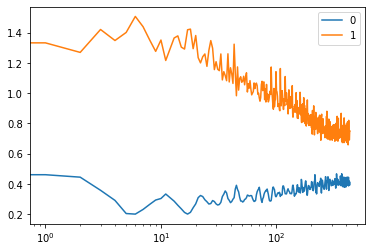

In [25]:
pd.DataFrame(np.array(epoch0_loss)).plot(logx=True)

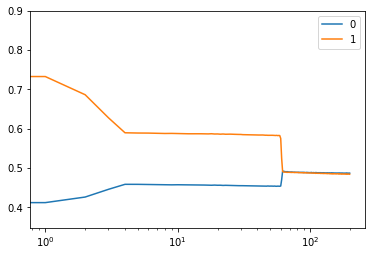

In [26]:
pd.DataFrame(np.array(l_loss)).plot(logx=True)

In [27]:
with gz.open('OUTPUT/loss_dup.pkl.gz', 'wb') as f:
    pkl.dump((epoch0_loss, l_loss), f)

In [28]:
error(error)

NameError: name 'error' is not defined

In [ ]:
gene_encoded10 = np.array(merged_model.gene_enc(TR_X2_GENE))

In [ ]:
with gz.open('OUTPUT/gene_enc.pkl.gz', 'wb') as f:
    pkl.dump(gene_encoded10, f)

In [ ]:
sns.distplot(gene_encoded10.flatten())

In [ ]:
total_len = len(TR_X1_SEQ)
L_pred = list()

for x_id in range(0, total_len, 1000):
    TR_1 = TR_X1_SEQ[x_id:x_id+1000]

    pred = merged_model(TR_1, TR_X2_GENE)
    NP_pred = np.array(pred, dtype=np.float16)
    
    L_pred.append(NP_pred)

NP_imputed = np.concatenate(L_pred)
del L_pred
gc.collect()

In [ ]:
NP_imputed.shape

In [ ]:
NP_Nucl = NP_imputed[:,:,0]
NP_Methyl = NP_imputed[:,:,1]

pd.DataFrame(NP_Nucl).to_csv('OUTPUT/pred_score_nucl.tsv', sep='\t', header=None, index=None)
pd.DataFrame(NP_Methyl).to_csv('OUTPUT/pred_score_methyl.tsv', sep='\t', header=None, index=None)

In [ ]:
Y_Nucl = TR_Y_PEAK[:,:,0]
Y_Methyl = TR_Y_PEAK[:,:,1]

pd.DataFrame(Y_Nucl).to_csv('OUTPUT/peak_nucl.tsv', sep='\t', header=None, index=None)
pd.DataFrame(Y_Methyl).to_csv('OUTPUT/peak_methyl.tsv', sep='\t', header=None, index=None)

In [ ]:
Error(Error)

## Make batch and train 10%

In [ ]:
TR_Y_PEAK_10pct = TR_Y_PEAK * (np.random.binomial(1, 0.9, TR_Y_PEAK.shape)).astype('float32')
TR_Y_ZERO_10pct = (TR_Y_PEAK_10pct < 0.1).astype('float32')

TR_Y_W0_0 = 1/(TR_Y_ZERO_10pct.mean(axis=0, keepdims=True) + 0.01) + 0.01
TR_Y_W1_0 = 1/(TR_Y_ZERO_10pct.mean(axis=1, keepdims=True) + 0.01) + 0.01
TR_Y_W0_1 = 1/(1-1/TR_Y_W0_0)
TR_Y_W1_1 = 1/(1-1/TR_Y_W1_0)

In [ ]:
TF_X1 = tf.data.Dataset.from_tensor_slices(TR_X1_SEQ)
TF_X2 = tf.constant(TR_X2_GENE)
TF_Y  = tf.data.Dataset.from_tensor_slices(TR_Y_PEAK_10pct)
TF_W1_0 = tf.data.Dataset.from_tensor_slices(TR_Y_W1_0)
TF_W1_1 = tf.data.Dataset.from_tensor_slices(TR_Y_W1_1)

training_dataset = tf.data.Dataset.zip( (TF_X1, TF_Y, TF_W1_0, TF_W1_1) )
training_dataset = training_dataset.batch( batch_size )
training_dataset = training_dataset.shuffle( TR_X1_SEQ.shape[0] )
training_dataset = training_dataset.prefetch( batch_size * 4 )

In [ ]:
merged_model = MergeingModel()
l_loss = list()
opt = tf.optimizers.Adamax(learning_rate=learning_rate)

In [ ]:
starting_epoch = len(l_loss)
for epoch in range(starting_epoch, epochs):
       
    epoch_loss = list()
    for step, batch_features in enumerate(training_dataset):
        train( loss, merged_model, opt, batch_features, TF_X2 )
        loss_values = loss_seq( merged_model, batch_features, TF_X2 )
 
        epoch_loss.append( loss_values )

    loss_sum = np.array( epoch_loss ).mean()
    l_loss.append( (loss_sum, 0) ) #np.float( loss_ae(merged_model, TF_X2)), ) )
    print('Epoch %d/%d' %(epoch, epochs), loss_sum)

In [ ]:
pd.DataFrame(np.array(l_loss)).plot(logx=True)

In [ ]:
gene_encoded10 = np.array(merged_model.gene_enc(TR_X2_GENE))

In [ ]:
with gz.open('OUTPUT/gene_enc_10pct.pkl.gz', 'wb') as f:
    pkl.dump(gene_encoded10, f)

In [ ]:
sns.distplot(gene_encoded10.flatten())

In [ ]:
total_len = len(TR_X1_SEQ)
L_pred = list()

for x_id in range(0, total_len, 1000):
    TR_1 = TR_X1_SEQ[x_id:x_id+1000]

    pred = merged_model(TR_1, TR_X2_GENE)
    NP_pred = np.array(pred, dtype=np.float16)
    
    L_pred.append(NP_pred)

NP_imputed = np.concatenate(L_pred)
del L_pred
gc.collect()

In [ ]:
NP_imputed.shape

In [ ]:
NP_Nucl = NP_imputed[:,:,0]
NP_Methyl = NP_imputed[:,:,1]

pd.DataFrame(NP_Nucl).to_csv('OUTPUT/pred_score_nucl_10pct.tsv', sep='\t', header=None, index=None)
pd.DataFrame(NP_Methyl).to_csv('OUTPUT/pred_score_methyl_10pct.tsv', sep='\t', header=None, index=None)

In [ ]:
Y_Nucl = TR_Y_PEAK_10pct[:,:,0]
Y_Methyl = TR_Y_PEAK_10pct[:,:,1]

pd.DataFrame(Y_Nucl).to_csv('OUTPUT/peak_nucl_10pct.tsv', sep='\t', header=None, index=None)
pd.DataFrame(Y_Methyl).to_csv('OUTPUT/peak_methyl_10pct.tsv', sep='\t', header=None, index=None)

## Make batch and train 20%

In [ ]:
TR_Y_PEAK_20pct = TR_Y_PEAK * (np.random.binomial(1, 0.8, TR_Y_PEAK.shape)).astype('float32')
TR_Y_ZERO_20pct = (TR_Y_PEAK_20pct < 0.1).astype('float32')

TR_Y_W0_0 = 1/(TR_Y_ZERO_20pct.mean(axis=0, keepdims=True) + 0.01) + 0.01
TR_Y_W1_0 = 1/(TR_Y_ZERO_20pct.mean(axis=1, keepdims=True) + 0.01) + 0.01
TR_Y_W0_1 = 1/(1-1/TR_Y_W0_0)
TR_Y_W1_1 = 1/(1-1/TR_Y_W1_0)

In [ ]:
TF_X1 = tf.data.Dataset.from_tensor_slices(TR_X1_SEQ)
TF_X2 = tf.constant(TR_X2_GENE)
TF_Y  = tf.data.Dataset.from_tensor_slices(TR_Y_PEAK_20pct)
TF_W1_0 = tf.data.Dataset.from_tensor_slices(TR_Y_W1_0)
TF_W1_1 = tf.data.Dataset.from_tensor_slices(TR_Y_W1_1)

training_dataset = tf.data.Dataset.zip( (TF_X1, TF_Y, TF_W1_0, TF_W1_1) )
training_dataset = training_dataset.batch( batch_size )
training_dataset = training_dataset.shuffle( TR_X1_SEQ.shape[0] )
training_dataset = training_dataset.prefetch( batch_size * 4 )

In [ ]:
merged_model = MergeingModel()
l_loss = list()
opt = tf.optimizers.Adamax(learning_rate=learning_rate)

In [ ]:
starting_epoch = len(l_loss)
for epoch in range(starting_epoch, epochs):
       
    epoch_loss = list()
    for step, batch_features in enumerate(training_dataset):
        train( loss, merged_model, opt, batch_features, TF_X2 )
        loss_values = loss_seq( merged_model, batch_features, TF_X2 )
 
        epoch_loss.append( loss_values )

    loss_sum = np.array( epoch_loss ).mean()
    l_loss.append( (loss_sum, 0) ) #np.float( loss_ae(merged_model, TF_X2)), ) )
    print('Epoch %d/%d' %(epoch, epochs), loss_sum)

In [ ]:
pd.DataFrame(np.array(l_loss)).plot(logx=True)

In [ ]:
gene_encoded10 = np.array(merged_model.gene_enc(TR_X2_GENE))

In [ ]:
with gz.open('OUTPUT/gene_enc_20pct.pkl.gz', 'wb') as f:
    pkl.dump(gene_encoded10, f)

In [ ]:
sns.distplot(gene_encoded10.flatten())

In [ ]:
total_len = len(TR_X1_SEQ)
L_pred = list()

for x_id in range(0, total_len, 1000):
    TR_1 = TR_X1_SEQ[x_id:x_id+1000]

    pred = merged_model(TR_1, TR_X2_GENE)
    NP_pred = np.array(pred, dtype=np.float16)
    
    L_pred.append(NP_pred)

NP_imputed = np.concatenate(L_pred)
del L_pred
gc.collect()

In [ ]:
NP_imputed.shape

In [ ]:
NP_Nucl = NP_imputed[:,:,0]
NP_Methyl = NP_imputed[:,:,1]

pd.DataFrame(NP_Nucl).to_csv('OUTPUT/pred_score_nucl_20pct.tsv', sep='\t', header=None, index=None)
pd.DataFrame(NP_Methyl).to_csv('OUTPUT/pred_score_methyl_20pct.tsv', sep='\t', header=None, index=None)

In [ ]:
Y_Nucl = TR_Y_PEAK_20pct[:,:,0]
Y_Methyl = TR_Y_PEAK_20pct[:,:,1]

pd.DataFrame(Y_Nucl).to_csv('OUTPUT/peak_nucl_20pct.tsv', sep='\t', header=None, index=None)
pd.DataFrame(Y_Methyl).to_csv('OUTPUT/peak_methyl_20pct.tsv', sep='\t', header=None, index=None)

## Make batch and train 50%

In [ ]:
TR_Y_PEAK_50pct = TR_Y_PEAK * (np.random.binomial(1, 0.5, TR_Y_PEAK.shape)).astype('float32')
TR_Y_ZERO_50pct = (TR_Y_PEAK_50pct < 0.1).astype('float32')

TR_Y_W0_0 = 1/(TR_Y_ZERO_50pct.mean(axis=0, keepdims=True) + 0.01) + 0.01
TR_Y_W1_0 = 1/(TR_Y_ZERO_50pct.mean(axis=1, keepdims=True) + 0.01) + 0.01
TR_Y_W0_1 = 1/(1-1/TR_Y_W0_0)
TR_Y_W1_1 = 1/(1-1/TR_Y_W1_0)

In [ ]:
TF_X1 = tf.data.Dataset.from_tensor_slices(TR_X1_SEQ)
TF_X2 = tf.constant(TR_X2_GENE)
TF_Y  = tf.data.Dataset.from_tensor_slices(TR_Y_PEAK_50pct)
TF_W1_0 = tf.data.Dataset.from_tensor_slices(TR_Y_W1_0)
TF_W1_1 = tf.data.Dataset.from_tensor_slices(TR_Y_W1_1)

training_dataset = tf.data.Dataset.zip( (TF_X1, TF_Y, TF_W1_0, TF_W1_1) )
training_dataset = training_dataset.batch( batch_size )
training_dataset = training_dataset.shuffle( TR_X1_SEQ.shape[0] )
training_dataset = training_dataset.prefetch( batch_size * 4 )

In [ ]:
merged_model = MergeingModel()
l_loss = list()
opt = tf.optimizers.Adamax(learning_rate=learning_rate)

In [ ]:
starting_epoch = len(l_loss)
for epoch in range(starting_epoch, epochs):
       
    epoch_loss = list()
    for step, batch_features in enumerate(training_dataset):
        train( loss, merged_model, opt, batch_features, TF_X2 )
        loss_values = loss_seq( merged_model, batch_features, TF_X2 )
 
        epoch_loss.append( loss_values )

    loss_sum = np.array( epoch_loss ).mean()
    l_loss.append( (loss_sum, 0) ) #np.float( loss_ae(merged_model, TF_X2)), ) )
    print('Epoch %d/%d' %(epoch, epochs), loss_sum)

In [ ]:
pd.DataFrame(np.array(l_loss)).plot(logx=True)

In [ ]:
gene_encoded10 = np.array(merged_model.gene_enc(TR_X2_GENE))

In [ ]:
with gz.open('OUTPUT/gene_enc_50pct.pkl.gz', 'wb') as f:
    pkl.dump(gene_encoded10, f)

In [ ]:
sns.distplot(gene_encoded10.flatten())

In [ ]:
total_len = len(TR_X1_SEQ)
L_pred = list()

for x_id in range(0, total_len, 1000):
    TR_1 = TR_X1_SEQ[x_id:x_id+1000]

    pred = merged_model(TR_1, TR_X2_GENE)
    NP_pred = np.array(pred, dtype=np.float16)
    
    L_pred.append(NP_pred)

NP_imputed = np.concatenate(L_pred)
del L_pred
gc.collect()

In [ ]:
NP_imputed.shape

In [ ]:
NP_Nucl = NP_imputed[:,:,0]
NP_Methyl = NP_imputed[:,:,1]

pd.DataFrame(NP_Nucl).to_csv('OUTPUT/pred_score_nucl_50pct.tsv', sep='\t', header=None, index=None)
pd.DataFrame(NP_Methyl).to_csv('OUTPUT/pred_score_methyl_50pct.tsv', sep='\t', header=None, index=None)

In [ ]:
Y_Nucl = TR_Y_PEAK_50pct[:,:,0]
Y_Methyl = TR_Y_PEAK_50pct[:,:,1]

pd.DataFrame(Y_Nucl).to_csv('OUTPUT/peak_nucl_50pct.tsv', sep='\t', header=None, index=None)
pd.DataFrame(Y_Methyl).to_csv('OUTPUT/peak_methyl_50pct.tsv', sep='\t', header=None, index=None)

In [ ]:
error

In [ ]:
L_cell_id = list(pd.read_csv('INPUT_1/ID_CELL.txt', header=None)[0])
pd.DataFrame(gene_encoded10, index=L_cell_id).to_csv('OUTPUT/gene_enc.tsv', sep='\t', header=None)

In [ ]:
#pred = merged_model(TR_X1_SEQ[:1000], TR_X2_GENE)

In [ ]:
#pred.shape

In [ ]:
y_hat_0 = NP_imputed[:total_len//2]
y_hat_1 = NP_imputed[total_len//2:]

In [ ]:
y_hat_mean = (y_hat_0 + y_hat_1)/2
y_hat_diff = np.abs(y_hat_0 - y_hat_1)
del y_hat_0
del y_hat_1

In [ ]:
T = (TR_Y_PEAK[:total_len//2]).astype(np.int8)
nT = T.sum()
F = (1-T)
nF = F.sum()

In [ ]:
cutline_list = np.concatenate(
    (np.arange(0, 0.3, 0.1),
     np.arange(0.31, 0.69, 0.01),
     np.arange(0.7, 1.0, 0.1)))

In [ ]:
#cutline_list = np.arange(0, 1.01,0.05)

In [ ]:
gc.collect()

In [ ]:
L_stat = list()
for diff_weight in np.arange(-0.5, 0.501, 0.25):
    y_hat_adj = y_hat_mean + diff_weight * y_hat_diff
    
    for cutline in cutline_list:
        adj = 0.99999 - cutline
        P = (y_hat_adj + adj).astype(np.int8)
        nP = P.sum()
        
        TP = T * P
        nTP = TP.sum()
        #print(nP, nTP)
        if nP==0:
            Prec = 1.0
            Recall = 0.0
        else:
            Prec   = nTP/nP
            Recall = nTP/nT
        
        FP = F * P
        nFP = FP.sum()
        FPR = nFP/nF
        
        F1 = 2*Prec*Recall/(Prec+Recall)
        F2 = 5*Prec*Recall/(4*Prec+Recall)

        print([diff_weight, cutline, Prec, Recall, F1, F2, FPR])
        L_stat.append([diff_weight, cutline, Prec, Recall, F1, F2, FPR])
    del y_hat_adj
    gc.collect()

In [ ]:
DF_stat = pd.DataFrame(L_stat, columns=['diff_weight', 'cutline', 'Prec', 'Recall', 'F1', 'F2', 'FPR'])

In [ ]:
DF_stat.to_csv('stat_dup.tsv', sep='\t', index=None)

In [ ]:
ERROR(ERROR)

In [ ]:
sns.heatmap(np.array(DF_stat['F1']).reshape(5,-1))

In [ ]:
sns.heatmap(np.array(DF_stat['F2']).reshape(5,-1))

In [ ]:
sns.lineplot(x='cutline', y='F2', hue='diff_weight', data=DF_stat, palette='Reds')
sns.lineplot(x='cutline', y='F1', hue='diff_weight', data=DF_stat, palette='Blues')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
center=(DF_stat['cutline']>0.4) & (DF_stat['cutline'] <0.7)

In [ ]:
DF_stat_center = DF_stat[ center ]
sns.lineplot(x='cutline', y='F1', hue='diff_weight', data=DF_stat_center, palette='Reds')
sns.lineplot(x='cutline', y='F2', hue='diff_weight', data=DF_stat_center, palette='Blues')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
sns.lineplot(x='cutline', y='Recall', hue='diff_weight', data=DF_stat)

In [ ]:
sns.lineplot(x='cutline', y='Prec', hue='diff_weight', data=DF_stat)

In [ ]:
ing for the group fiksns.lineplot(x='cutline', y='FPR', hue='diff_weight', data=DF_stat)

In [ ]:
sns.lineplot(x='FPR', y='Recall', hue='diff_weight', data=DF_stat)
sns.lineplot(x=[0,1], y=[0,1])

In [ ]:
y_hat_adj

In [ ]:
L_stat2 = list()
y_hat_adj = y_hat_mean
    
for cutline in cutline_list:
    adj = 0.99999 - cutline
    P = (y_hat_adj + adj).astype(np.int8)
    nP = P.sum()

    TP = T * P
    nTP = TP.sum()

    if nP==0:
        Prec = 1.0
        Recall = 0.0
    else:
        Prec   = nTP/nP
        Recall = nTP/nT

    FP = F * P
    nFP = FP.sum()
    
    for hR in [0.0, 0.15, 0.3, 0.45]:
        hTr  = nF * hR
        hTPr = hTr * Recall
        hFPR  = (nFP - hTPr)/(nF - hTr)

        print([cutline, hR, Recall, hFPR])
        L_stat2.append([cutline, hR, Recall, hFPR])
del y_hat_adj
gc.collect()

In [ ]:
DF_stat2 = pd.DataFrame(L_stat2, columns=['cutline', 'hidden_rate', 'Recall', 'FPR'])

In [ ]:
sns.lineplot(x='FPR', y='Recall', hue='hidden_rate', data=DF_stat2)
sns.lineplot(x=[0,1], y=[0,1])

In [ ]:
L_stat0 = list()
y0 = y_hat_mean[:,:,0]
T0 = T[:,:,0]
nT0 = T0.sum()
F0 = F[:,:,0]
nF0 = F0.sum()
    
for cutline in cutline_list:
    adj = 0.99999 - cutline
    P = (y0 + adj).astype(np.int8)
    nP = P.sum()

    TP = T0 * P
    nTP = TP.sum()

    if nP==0:
        Prec = 1.0
        Recall = 0.0
    else:
        Prec   = nTP/nP
        Recall = nTP/nT0

    FP = F0 * P
    nFP = FP.sum()
    
    for hR in [0.0, 0.15, 0.3, 0.45]:
        hTr  = nF0 * hR
        hTPr = hTr * Recall
        hFPR  = (nFP - hTPr)/(nF0 - hTr)

        print([cutline, hR, Recall, hFPR])
        L_stat0.append([cutline, hR, Recall, hFPR])
gc.collect()

In [ ]:
DF_stat0 = pd.DataFrame(L_stat0, columns=['cutline', 'hidden_rate', 'Recall', 'FPR'])

In [ ]:
sns.lineplot(x='FPR', y='Recall', hue='hidden_rate', data=DF_stat0)
sns.lineplot(x=[0,1], y=[0,1])

In [ ]:
L_stat1 = list()
y1 = y_hat_mean[:,:,1]
T1 = T[:,:,1]
nT1 = T1.sum()
F1 = F[:,:,1]
nF1 = F1.sum()
    
for cutline in cutline_list:
    adj = 0.99999 - cutline
    P = (y1 + adj).astype(np.int8)
    nP = P.sum()

    TP = T1 * P
    nTP = TP.sum()

    if nP==0:
        Prec = 1.0
        Recall = 0.0
    else:
        Prec   = nTP/nP
        Recall = nTP/nT1

    FP = F1 * P
    nFP = FP.sum()
    
    for hR in [0.0, 0.15, 0.3, 0.45]:
        hTr  = nF1 * hR
        hTPr = hTr * Recall
        hFPR  = (nFP - hTPr)/(nF1 - hTr)

        print([cutline, hR, Recall, hFPR])
        L_stat1.append([cutline, hR, Recall, hFPR])
gc.collect()

In [ ]:
DF_stat1 = pd.DataFrame(L_stat1, columns=['cutline', 'hidden_rate', 'Recall', 'FPR'])

In [ ]:
sns.lineplot(x='FPR', y='Recall', hue='hidden_rate', data=DF_stat1)
sns.lineplot(x=[0,1], y=[0,1])